# Importing packages

In [1]:
import pandas as pd  
import numpy as np 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score

from preprocessing import *

# Function definitions

Function to convert a data array back to a dataframe and restore the datatypes. Only restores datatypes `bool`, `int64`, and `string`.

Input:
 - `data_array`: an array that is a subset of the original dataframe `og_df`. All features of `og_df` should be included in the `data_array`, except for the ones in `exclude`

 - `og_df`: the original dataframe

 - `exclude`: an array containing the names of the features that are present in `og_df`, but not in `data_array`
 
Returns:
 - the given array `data_array` as a dataframe

In [2]:
def to_df_restore_dtypes(data_array, og_df, exclude):
    col_names = og_df.drop(exclude, axis=1).columns.tolist() 
    arr_df = pd.DataFrame(data_array, columns = col_names)
    
    bool_columns = og_df.drop(exclude, axis=1).select_dtypes(include='bool').columns.tolist() 
    int_columns  = og_df.drop(exclude, axis=1).select_dtypes(include='int64').columns.tolist() 
    str_columns  = og_df.drop(exclude, axis=1).select_dtypes(include='string').columns.tolist() 
    
    arr_df[bool_columns] = arr_df[bool_columns].astype('bool')
    arr_df[int_columns]  = arr_df[int_columns].astype('int64')
    arr_df[str_columns]  = arr_df[str_columns].astype('string')
    
    return arr_df

Print the confusion matrix.

In [3]:
def print_confusion_matrix(true, pred, t=0.5):
    pred_binary = [1 if y >= t else 0 for y in pred]
    cm = confusion_matrix(true, pred_binary)
    tn, fp, fn, tp = cm.ravel()
    
    print('confusion matrix:')
    print(cm)
    print()
    print('true positives: ', tp)
    print('false positives:', fp)
    print('true negatives: ', tn)
    print('false negatives:', fn)
    print()

Define scoring functions.

In [4]:
# define possible scoring functions

# precision: tp / (tp + fp), the ability not to label a negative as a positive
# recall   : tp / (tp + fn), the ability to find all the positive samples
# accuracy : proportion of labels that is predicted correctly


def own_scorer_func_01(y_true, y_prob):
    df = pd.DataFrame(y_prob, columns = ['prob'])
    df['true'] = y_true
    
    sorted_df = df.sort_values(by='prob', ascending=False)

    top_250 = sorted_df.iloc[:250,:]
    y_prob_250 = top_250['prob'].to_numpy()
    y_true_250 = top_250['true'].to_numpy()
    # The top 250 instances are classified as positives
    y_pred_250 = np.ones(y_true_250.shape)
    
    rest = sorted_df.iloc[250:,:]
    y_prob_rest = rest['prob'].to_numpy()
    y_true_rest = rest['true'].to_numpy()
    # Observations not in the top 250 are classified as negatives
    y_pred_rest = np.zeros(y_true_rest.shape)
    
    # you want many true positives and few false positives in the top 250
    precision_250 = precision_score(y_true_250, y_pred_250, zero_division=0)
    
    # you want few false negatives and many true negatives in the rest of the data set
    neg_precision_rest = precision_score(y_true_rest, y_pred_rest, pos_label=0, zero_division=0)    
    
    # take the product instead of the sum so if one of them is zero, the result is zero
    return precision_250 * neg_precision_rest 


def own_scorer_func_02(y_true, y_prob):

    df = pd.DataFrame(y_prob, columns = ['prob'])
    df['true'] = y_true
    
    top_250 = df.sort_values(by='prob', ascending=False).iloc[:250,:]
    y_true_250 = top_250['true'].to_numpy()
    
    nb_churn_250 = np.sum(y_true_250[y_true_250==1])
    
    # number of churners that is in the top 250
    return nb_churn_250

def own_scorer_func_02_df(y_true, y_prob):

    df = pd.DataFrame(y_prob)
    df.columns = ['prob']
    df['true'] = y_true.to_numpy()
    top_250 = df.sort_values(by='prob', ascending=False).iloc[:250,:]
    y_true_250 = top_250['true'].to_numpy()
    
    nb_churn_250 = np.sum(y_true_250[y_true_250==1])
    
    # number of churners that is in the top 250
    return nb_churn_250


def own_scorer_func_03(y_true, y_prob):
    df = pd.DataFrame(y_prob, columns = ['prob'])
    df['true'] = y_true
    
    top_250 = df.sort_values(by='prob', ascending=False).iloc[:250,:]
    y_true_250 = top_250['true'].to_numpy()
    
    nb_churn_250 = np.sum(y_true_250[y_true_250==1])
    
    # proportion of top 250 that are churners
    return nb_churn_250/250

Source for following function: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65 (has been modified)

In [5]:
def grid_search_wrapper(X_train, y_train, X_val, y_val, refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    """
    skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, verbose=2)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_val)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    return grid_search

# Split the data

Separate the features and target and convert to arrays (necessary for using sklearn). Split the data into training and test set (75-25). `client_id` should be dropped later on, because this feature should not be used for making predictions.

In [6]:
train_m3 = pd.read_csv('data/train_month_3_with_target.csv')
test_m3 = pd.read_csv('data/test_month_3.csv')

X = train_m3.drop('target', axis=1).to_numpy()
y = train_m3['target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Random forests

Preprocess, convert the data back to arrays so it can be used with the sklearn methods. Convert the targets from boolean to integer.

In [7]:
# preprocces
X_train_df = to_df_restore_dtypes(X_train, train_m3, 'target')
X_test_df = to_df_restore_dtypes(X_test, train_m3, 'target')

data = preprocess(X_train_df, X_test_df, test_m3, 3)
X_train_df = data[0]
X_test_df = data[1]
test_m3 = data[2]

# convert to arrays
full_feature_set = list(set(X_train_df.columns.tolist()) - {'remainder__client_id'}) 
used_features = full_feature_set

X_train_df = X_train_df[used_features]
X_train_arr = X_train_df.to_numpy()

test_client_id = X_test_df.pop('remainder__client_id')  
X_test_df = X_test_df[used_features]
X_test_arr = X_test_df.to_numpy()

# convert from boolean to int
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [9]:
clf = RandomForestClassifier(bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

In [10]:
# define parameters to determine through cross validation
param_grid = {
    'class_weight': ['balanced'], 
    'max_features': ["sqrt", 0.1, 0.2],
    'max_samples': [50, 100], 
    'n_estimators': [500, 1000]
}

scorers = {
    'own_scorer_01': make_scorer(own_scorer_func_01, greater_is_better=True, needs_proba=True),
    'own_scorer_02': make_scorer(own_scorer_func_02, greater_is_better=True, needs_proba=True),
    'own_scorer_03': make_scorer(own_scorer_func_03, greater_is_better=True, needs_proba=True)
}

The best model:
   
 - 10 fold    
 - preprocess('train_month_3_with_target.csv', 'test_month_3.csv', 3)
 - own_scorer_02 (after small change)
 - 'class_weight': ['balanced', {0:1, 1:500}, None],  
 - 'max_features': ["sqrt", 0.05, 0.1, 0.2, 0.3, 0.5],
 - 'max_samples': [50, 100], 
 - 'n_estimators': [500, 750, 1000]
 - best: `{'class_weight': 'balanced', 'max_features': 0.2, 'max_samples': 100, 'n_estimators': 500}`
 - number of churners in top 250:              37
 - total number of churners:                   478
 - percentage of top 250 that are churners:    14.8 %
 - percentage of churners that is in top 250:  7.7 %
 - `out09`

In [ ]:
grid_search_clf = grid_search_wrapper(X_train_arr, y_train, X_test_arr, y_test, refit_score='own_scorer_02')

In [ ]:
y_prob = grid_search_clf.predict_proba(X_test_arr)[:, 1]
y_pred = grid_search_clf.predict(X_test_arr)

prediction = pd.DataFrame(y_prob, columns = ['prob'])
prediction['true'] = y_test.tolist()
prediction['pred'] = y_pred

sorted_df = prediction.sort_values(by='prob', ascending=False)

top_250 = sorted_df.iloc[:250,:]
y_prob_250 = top_250['prob'].to_numpy()
y_true_250 = top_250['true'].to_numpy()
# The top 250 instances are classified as positives
y_pred_250 = np.ones(y_true_250.shape)

rest = sorted_df.iloc[250:,:]
y_prob_rest = rest['prob'].to_numpy()
y_true_rest = rest['true'].to_numpy()
# Observations not in the top 250 are classified as negatives
y_pred_rest = np.zeros(y_true_rest.shape)

new_y_true = np.concatenate((y_true_250, y_true_rest), axis=0)
new_y_pred = np.concatenate((y_pred_250, y_pred_rest), axis=0)

print_confusion_matrix(new_y_true, new_y_pred)

In [ ]:
nb_churn_total = np.sum(y_test[y_test==1])
nb_churn_250 = np.sum(y_true_250[y_true_250==1])

print('number of churners in top 250:             ', nb_churn_250)
print('total number of churners:                  ', nb_churn_total)
print('percentage of top 250 that are churners:   ', np.round(100*nb_churn_250/250,1), '%')
print('percentage of churners that is in top 250: ', np.round(100*nb_churn_250/nb_churn_total,1), '%')

Apply to data for leaderboard.

In [ ]:
test_client_id = test_m3.pop('remainder__client_id') 
test_m3_df = test_m3[used_features]
test_m3_arr = test_m3_df.to_numpy()

In [ ]:
y_prob_test = grid_search_clf.predict_proba(test_m3_arr)[:, 1]

test_prediction = pd.DataFrame(test_client_id, columns = ['remainder__client_id'])
test_prediction['y_prob_test'] = y_prob_test.tolist()

In [ ]:
#test_prediction.to_csv('out09.csv',header=False, index=False)

# Interpretability

## Partial dependence plots                 

In [15]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [9]:
grid_search_clf = RandomForestClassifier(class_weight='balanced', max_features=0.2, max_samples=100, n_estimators=500,
                                          bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
grid_search_clf.fit(X_train_arr, y_train)

RandomForestClassifier(class_weight='balanced', max_features=0.2,
                       max_samples=100, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=42)

In [111]:
fnames = X_train_df.columns.tolist()

numeric = ['remainder__customer_age', 
           
           'remainder__cap_life_insurance_decreasing_cap', 
           #'remainder__cap_life_insurance_fixed_cap',
           'remainder__prem_fire_car_other_insurance',
           
           'remainder__bal_mortgage_loan',
           'remainder__bal_personal_loan',
           
           'remainder__customer_since_bank_years', 
           'remainder__customer_since_all_years',
           
           'remainder__visits_distinct_so', 
           'remainder__visits_distinct_so_areas',
           
           'remainder__bal_savings_account',  
           'remainder__bal_savings_account_starter',
           'remainder__bal_current_account',
           'remainder__bal_current_account_starter',
           
           'remainder__bal_pension_saving',
           
           'remainder__bal_insurance_21',
           #'remainder__bal_insurance_23'
          ]

binary = ['onehotencoder__customer_children_grownup',
          'onehotencoder__customer_children_mature',
          'onehotencoder__customer_children_no', 
          'onehotencoder__customer_children_onebaby', 
          'onehotencoder__customer_children_preschool', 
          'onehotencoder__customer_children_yes', 
          'onehotencoder__customer_children_young', 
          'remainder__customer_children_missing', 
          
          'onehotencoder__customer_education_1.0',
          'onehotencoder__customer_education_2.0', 
          'onehotencoder__customer_education_3.0',
          'onehotencoder__customer_education_4.0', 
          'onehotencoder__customer_education_5.0',
          'onehotencoder__customer_education_6.0', 
          'remainder__customer_education_missing',
          
          'onehotencoder__customer_occupation_code_1.0',
          'onehotencoder__customer_occupation_code_2.0',
          'onehotencoder__customer_occupation_code_3.0',
          'onehotencoder__customer_occupation_code_4.0', 
          'onehotencoder__customer_occupation_code_5.0',
          'onehotencoder__customer_occupation_code_6.0', 
          'onehotencoder__customer_occupation_code_7.0',
          'onehotencoder__customer_occupation_code_8.0', 
          'onehotencoder__customer_occupation_code_9.0',
          'remainder__customer_occupation_code_missing',
          'remainder__customer_self_employed',
          
          'onehotencoder__customer_postal_code_1', 
          'onehotencoder__customer_postal_code_2',
          'onehotencoder__customer_postal_code_3', 
          'onehotencoder__customer_postal_code_4',
          'onehotencoder__customer_postal_code_5', 
          'onehotencoder__customer_postal_code_6',
          'onehotencoder__customer_postal_code_7', 
          'onehotencoder__customer_postal_code_8',
          'onehotencoder__customer_postal_code_9', 
          
          'onehotencoder__customer_relationship_single',
          'remainder__customer_relationship_missing',
           
          'remainder__customer_gender',
          
          'remainder__customer_since_all_missing', 
          'remainder__customer_since_bank_missing',
          
          'remainder__has_current_account',
          'remainder__has_current_account_starter',
          'remainder__has_savings_account',
          'remainder__has_savings_account_starter',
          'remainder__has_fire_car_other_insurance', 
          'remainder__has_life_insurance_decreasing_cap',
          'remainder__has_life_insurance_fixed_cap', 
          'remainder__has_insurance_21',
          'remainder__has_insurance_23', 
          'remainder__has_homebanking', 
          'remainder__homebanking_active',
          'remainder__has_mortgage_loan', 
          'remainder__has_personal_loan', 
          'remainder__has_pension_saving']

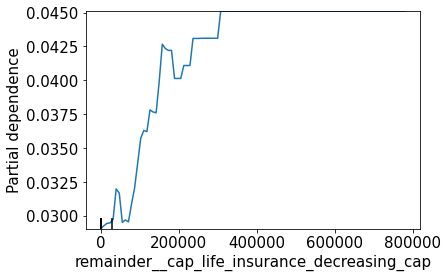

In [122]:
pdp = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=['remainder__cap_life_insurance_decreasing_cap'], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

In [123]:
pdp1 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=['remainder__cap_life_insurance_fixed_cap',
                                                         'remainder__bal_insurance_23',
                                                         'remainder__cap_life_insurance_decreasing_cap'], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

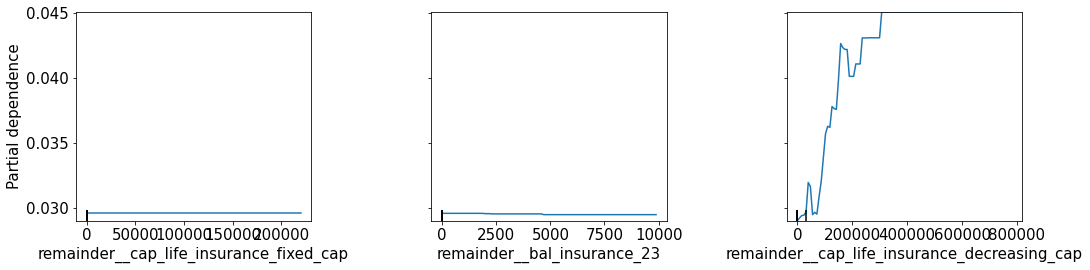

In [121]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[15,4])
axs = plt.subplot(1, 3, (1,3))
pdp1.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 8)
plt.savefig("pdp1")
plt.show()

In [207]:
pdp2 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=numeric, 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

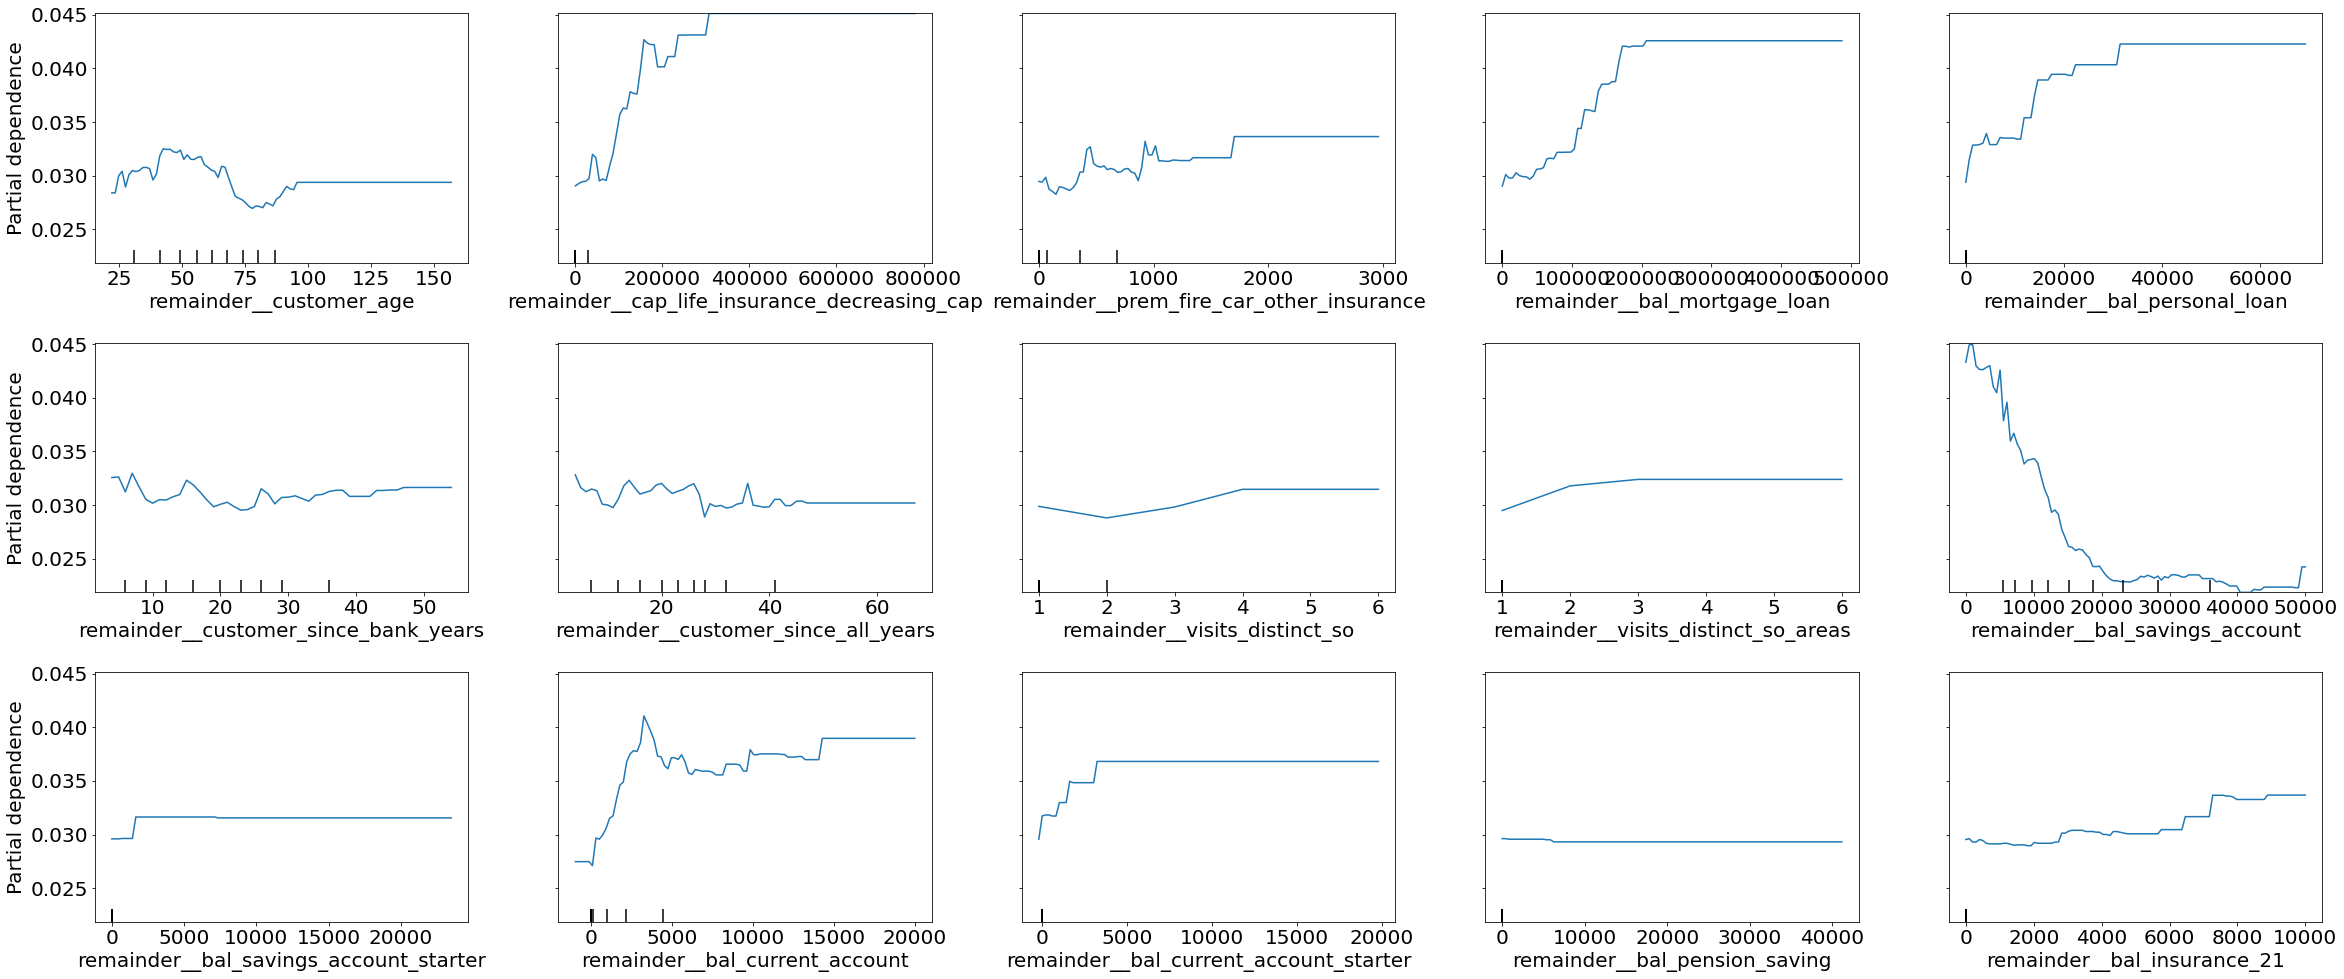

In [206]:
fig = plt.figure(figsize=[33,14])
axs = plt.subplot(3, 5, (1,15))

fsize = 20
plt.rc('font', size=fsize)  
plt.rc('axes', labelsize=fsize) 

pdp2.plot(ax=axs, n_cols=5)

plt.tight_layout(h_pad = 4, w_pad = 4.5)
plt.savefig("pdp2")
plt.show()

In [208]:
pdp3 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=binary[:8], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

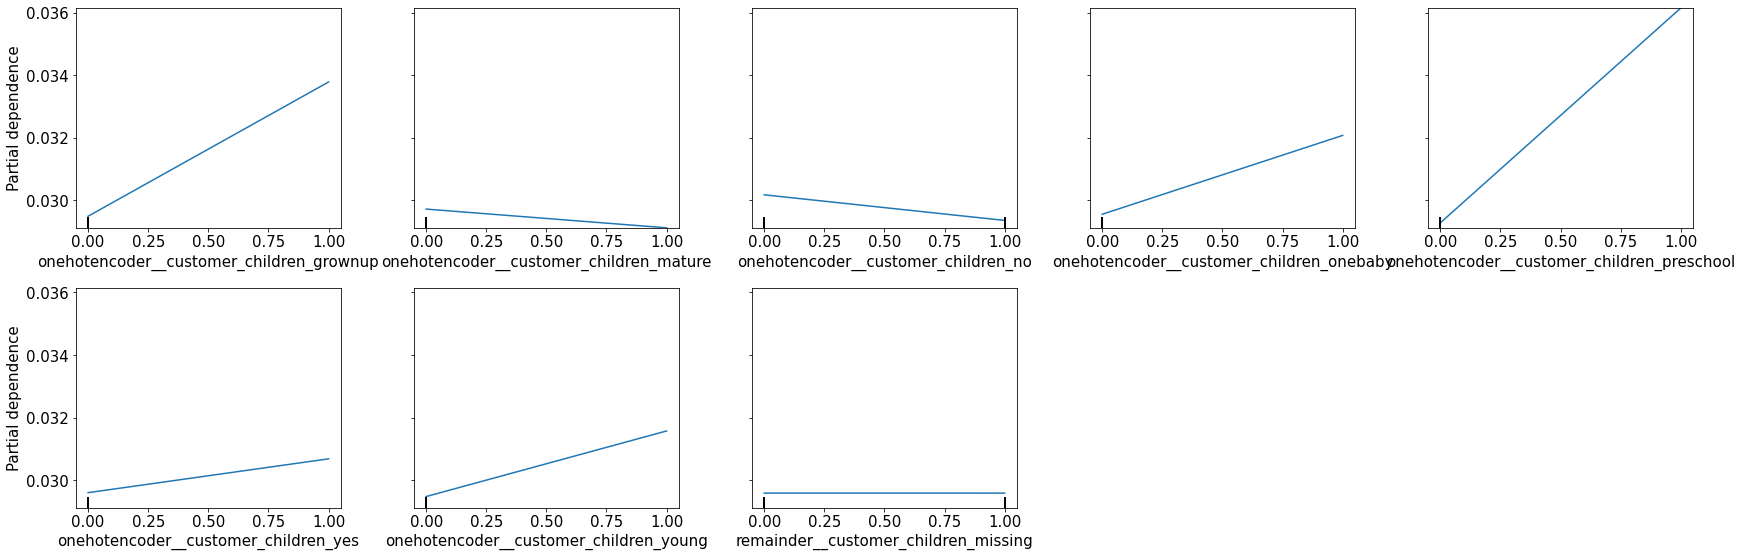

In [156]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[40,8])
axs = plt.subplot(2, 5, (1,8))
pdp3.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 8)
plt.savefig("pdp3")
plt.show()

In [209]:
pdp4 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=binary[8:15], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

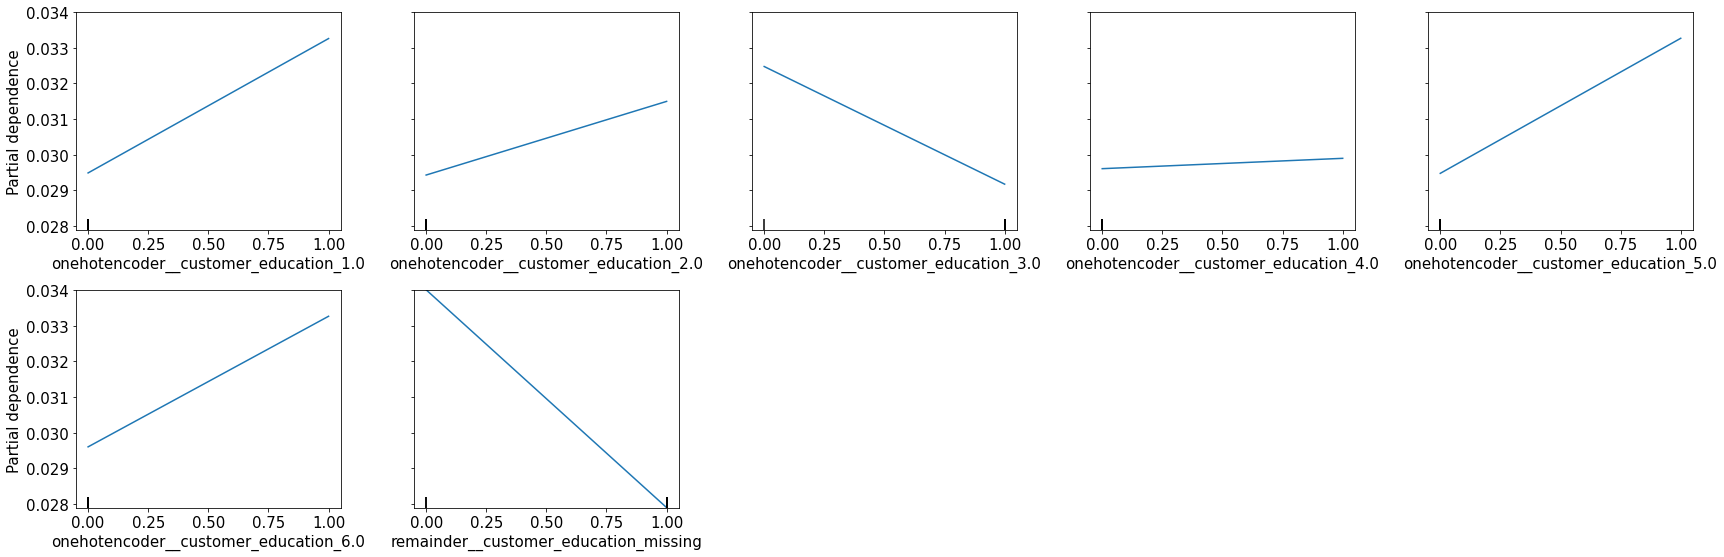

In [157]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[40,8])
axs = plt.subplot(2, 5, (1,8))
pdp4.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 8)
plt.savefig("pdp4")
plt.show()

In [210]:
pdp5 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=binary[15:26], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

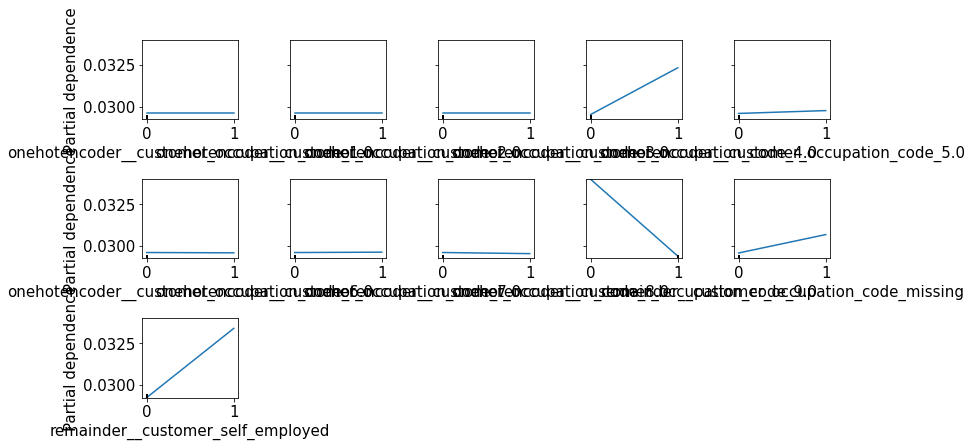

In [174]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[70,6])
axs = plt.subplot(3, 5, (1,11))
pdp5.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 25)
plt.savefig("pdp5")
plt.show()

In [211]:
pdp6 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=binary[26:35], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

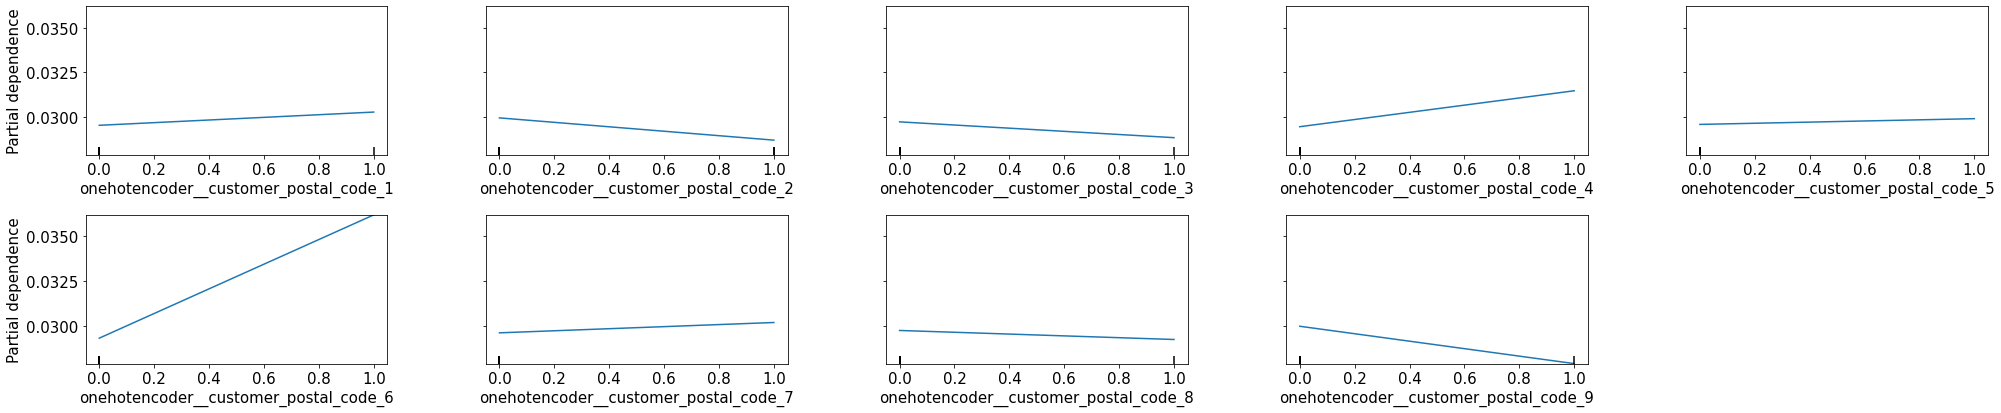

In [166]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[35,6])
axs = plt.subplot(2, 5, (1,9))
pdp6.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 8)
plt.savefig("pdp6")
plt.show()

In [212]:
pdp7 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=binary[35:40], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

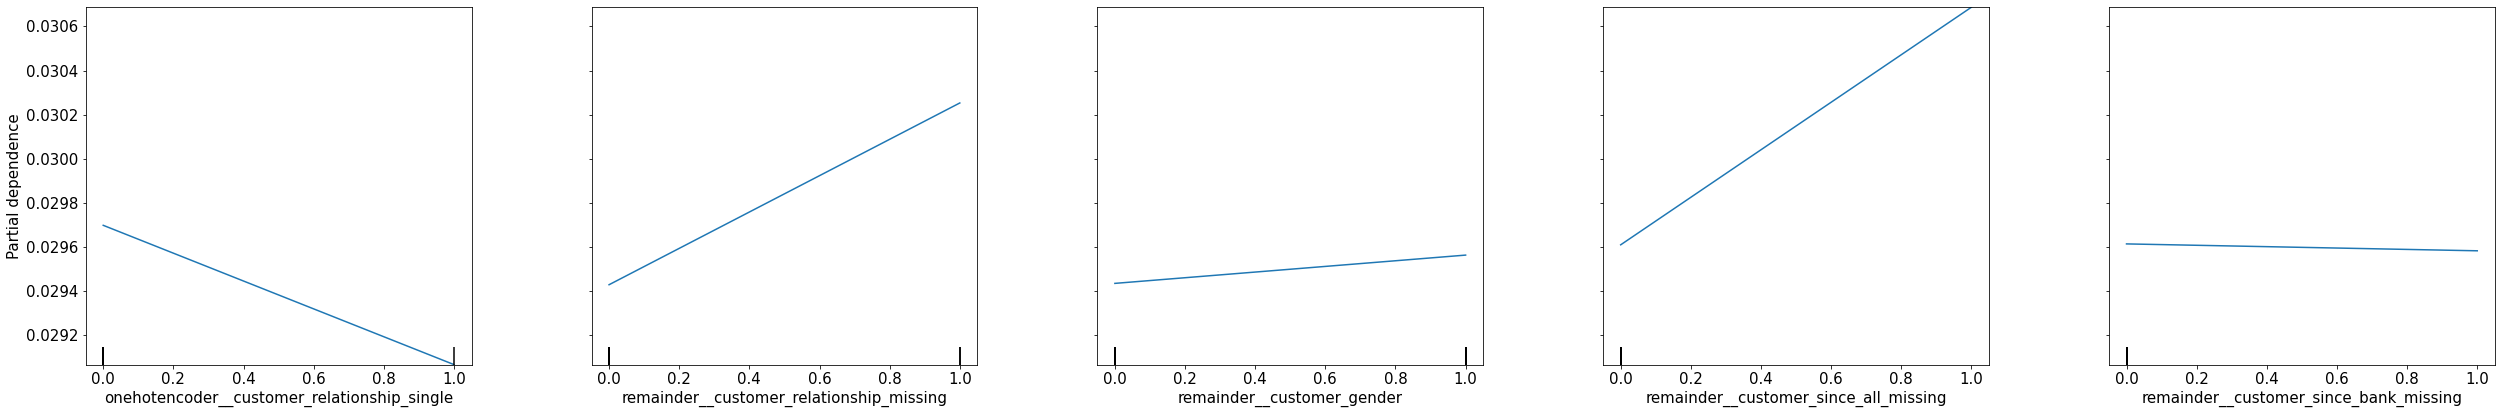

In [167]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[35,6])
axs = plt.subplot(1, 5, (1,5))
pdp7.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 8)
plt.savefig("pdp7")
plt.show()

In [213]:
pdp8 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=binary[40:49], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

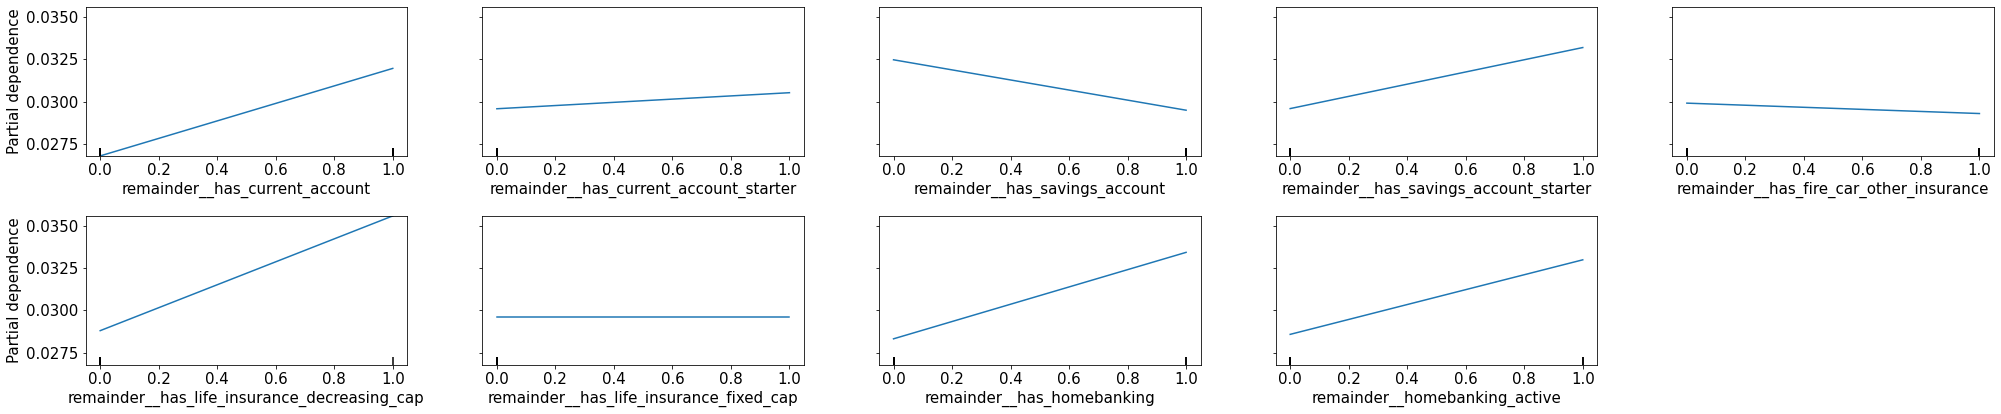

In [169]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[35,6])
axs = plt.subplot(2, 5, (1,9))
pdp8.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 6)
plt.savefig("pdp8")
plt.show()

In [214]:
pdp9 = PartialDependenceDisplay.from_estimator(grid_search_clf, X_train_arr,
                                               features=binary[49:], 
                                               feature_names=fnames,
                                               kind='average', n_cols=5, percentiles=(0, 1))

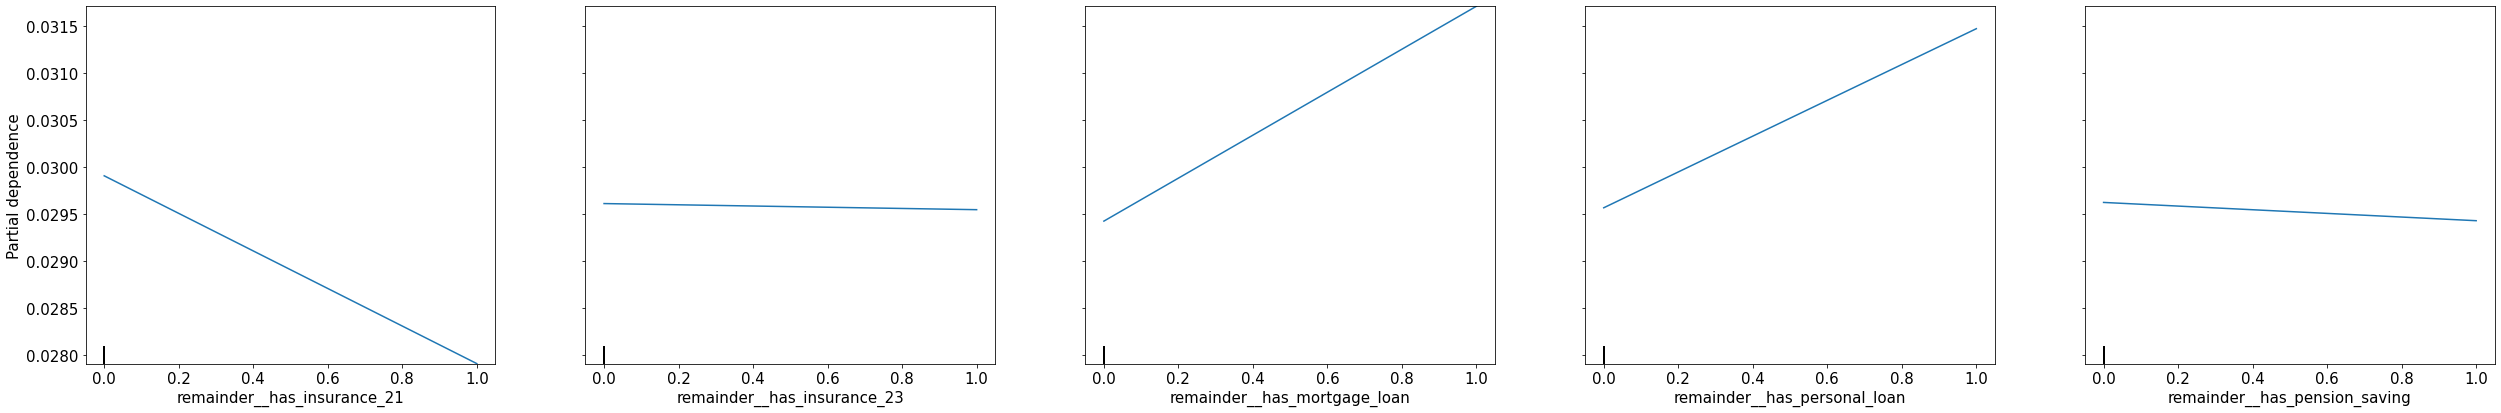

In [170]:
plt.rc('font', size=15) 
fig = plt.figure(figsize=[35,6])
axs = plt.subplot(1, 5, (1,5))
pdp9.plot(ax=axs, n_cols=5)
plt.tight_layout(h_pad = 4, w_pad = 6)
plt.savefig("pdp9")
plt.show()